# EMI mechanical model – part 1

The EMI framework, in which we explicitly represents the extra- and intracellular subdomains geometrically, can also be used for mechanical modeling of the cells. The equations are somewhat different, but the core idea remains the same – that what happens inside the cells is fundamentally different from what happens outside of the cells; and by averaging these out we are missing out interactions taking place on a microscale level.

The EMI model is, unlike myofilament level models and like tissue-level models, a continuum-based model. That implies that we take spatial patterns into account and look for solutions in a three-dimensional space, modeled by partial differential equations (PDEs). PDEs are in their nature more computationally expensive than ODEs, as there are so many more unknowns to solve for. They do, however, give us a tool for investigating the impact of different geometries and spatial variations.

We will use the code from the repository [emimechanicalmodel](https://github.com/aashildte/emimechanicalmodel/), which is based on FEniCS. We can import all libraries we need as following:

In [12]:
import numpy as np
import matplotlib.pyplot as plt

import fenics as f
import emimechanicalmodel as emi_m

f.set_log_level(30)        # less verbatim output from the Newton solver compared to default

You don't really need to know much FEniCS in advance to run the code - we will guide you through what you need to know.

## Geometries and meshes

We can start by reading in the mesh and subdomain information:

In [13]:
mesh_file = "meshes/tile_connected_10p0.h5"
mesh, volumes = emi_m.load_mesh(mesh_file)

Mesh and subdomains loaded successfully.
Number of nodes: 335, number of elements: 1364


Here, the mesh object gives us a tetrahedral representation of our geometry (all nodes and edges) and volumes is a so-called MeshFunction which tells us which elements (tetrahedra) belongs to the intracellular space, and which elements belongs to the extracellular space. We can actually print the meshfunction's "array" representation to see the data:

In [14]:
print("Subdomain data length: ", len(volumes.array()[:]))
print("Subdomain data: ", volumes.array()[:])

Subdomain data length:  1364
Subdomain data:  [1 1 1 ... 0 0 0]


Here, all the ones represent the cell (the intracellular subdomain) and all the zeros the matrix (the extracellular subdomain).

We can save the volumes object to a pvd file:

In [15]:
f.File("subdomains.pvd") << volumes

In the code you are running the notebook from, you should now have a file called "subdomains.pvd", as well as a file called "subdomains000000.vtu", which belong together. You can open either of these in Paraview, and inspect the output. Through Paraview we can visualize the subdomains and the mesh representation, which for our sample mesh can look like this:

![title](figures/subdomains_meshes_tile_connected_10p0.png)

We will denote the intracellular subdomain, i.e., the cell, by $\Omega_i$, and the extracellular subdomain, i.e., the matrix, by $\Omega_e$.

## Fundamental equations

When we solve the mechanical problem, we want to find a displacement field $\mathbf{u}$ which gives us an _equilibrium of stresses_. We are, essentially, solving for a three-dimensional version of Newton's third law, expressed by Piola-Kirchhoff stress tensor $\mathbf{P}$:

$$\nabla \cdot \mathbf{P} = 0$$

We allow for free contraction on all sides, such that all forces we deal with are generated by the cell itself. In addition, we need to account for stiffness of each subdomain. The stiffer either is, the harder it will be for the cell to contract. We won't go into details of the derivation, but in short, we can express $P$ as following:

$$ P = \frac{\partial \Psi_{passive} (F)}{\partial F} + \frac{\partial \Psi_{active} (F)}{\partial F}$$

Here we are using an _active stress_ approach, in which active contraction is added in an additive manner. The other option is an _active strain_ approach. Both are reasonable choices, but the active stress approach might be easier to connect to physiological relevant quantities. 

## Passive contribution

The core of the EMI model is that both $\psi_{passive}$ and $\psi_{active}$ are defined differently for each subdomain. Starting with $\psi_{passive}$, we can separate it into two separate contributions:

$$ \Psi_{passive} (F) = \begin{cases} \Psi_{i} (F) \qquad x \in \Omega_i \\ \Psi_{e} (F) \qquad x \in \Omega_e \end{cases} $$

This is, as you might notice, _not_ defined at the membrane itself, i.e., the surface separating the two subdomains. That is, however, not so important; you might think of it as that we assume, for simplicity, that the membrane has zero stiffness (which is not exactly right, but it works for our purposes).

We assume that the intracellular subdomain can be modeled as a _transversely isotropic_ material, which means that the cells are somewhat stiffer in the longitudinal direction than in the other directions. We can express this by components of the Cauchy-Green strain tensor $\mathbf{E}$, which often is called a Guccione (or a Fung) kind of model:

$$ \Psi_i = C_i (e^{Q_i} - 1) + \kappa_i (J \ln J - J + 1) \quad \qquad \mathbf{x} \in \Omega_{i} $$

The parameter $C_i$ has unit kPa, and adjusting will adjust the stiffness of the cell. Furthermore, the term $Q_i$ determines the exponential behavior of increasing amounts of strain:

$$ Q_i = b_{f, i} E_{11}^{2} + b_{t, i}(E_{22}^{2} + E_{33}^{2} + E_{23}^{2} + E_{32}^{2}) + b_{ft, i}(E_{12}^{2} + E_{21}^{2} + E_{13}^{2} + E_{31}^{2}) $$

Here we have chosen $b_{f, i} = 8$, $b_{t, i} = 2$, $b_{ft, i} = 4$. These parameters determine the ratio between the fiber direction ($b_{f, i}$), the transverse direction ($b_{t, i}$) and the transverse direction ($b_{ft, i}$). If they are all equal, the material can be called _isotropic_.

The term $\kappa_i (J \ln J - J + 1)$ helps us model the material as nearly incompressible; we could spend another seciton on defining this and variants (feel free to ask the lecturer), but for simplicity, for now, we are just going to accept that it is a part of the strain energy function.

Next, for the extracellular space, we will use

$$ \Psi_e = C_e (e^{Q_e} - 1) + \kappa_e (J \ln J - J + 1) \quad \qquad \mathbf{x} \in \Omega_{i} $$

where

$$ Q_e = b_e (E_{11}^{2} + E_{22}^{2} + E_{33}^{2} + E_{23}^{2} + E_{32}^{2}) + E_{12}^{2} + E_{21}^{2} + E_{13}^{2} + E_{31}^{2}) $$

Mathematically, this term is equal to $Q_i$ but with all parameters equal to $b_e$. Physiologically, this implies that the material is isotropic with material properties determined by $C_e$ and $b_e$, as well as the incompressibility paramter $\kappa_e$.

# Active contribution

The separation of active contribution in the different subdomains is, in comparison to the passive part, pretty straight forward: We assume that the cells contract – with a non-zero contribution – and that the matrix does not contract. Mathematically we can say that the active tension is zero in the extracellular subdomain:

$$
\Psi_{active} = \begin{cases} \frac{T_{active}(t)}{2} || F f ||^2 \qquad \qquad \ x \in \Omega_i \\ 0 \qquad \quad \qquad \qquad \qquad x \in \Omega_e \end{cases}
$$

We will use the force calculated from the Rice model to calculate $T_{active} (t)$. Note that this is _weakly_ coupled; we are not giving the local strain (which can be translated to the change in the sarcomere length) back to the Rice model. Physiologically this would have made most sense, but this is a non-trivial task – that no-one so far has been able to do for the EMI model!

We have, for convenience, precalculated the force transient which we will read in for now. Later on, we'll play with some of the parameters to get different active tension transients based on changes in calcium and myofilament dynamics. We can read in, and plot, the pre-calculated values as follows:

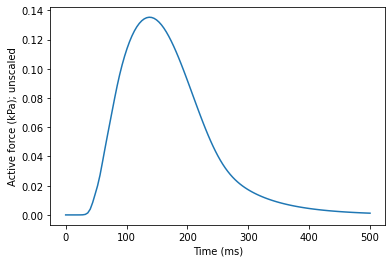

In [16]:
time = np.linspace(0, 500, 125)       # 500 ms with 125 steps

active_precomputed, _ = emi_m.compute_active_component(time)

plt.plot(time, active_precomputed)
plt.xlabel("Time (ms)")
plt.ylabel("Active force (kPa); unscaled")
plt.show()

This is meant to resemble half of a single beat (up t0 500 ms, out of 1000).

## Running the EMI model

With the theory explained, let's move on to the actual coding! From the emimechanicalmodel library, we can make an instance of the EMI model which is based on all the equations above - predefined for us. You hence won't need to worry about getting any of the equations right; your main task will be to adjust the different parameters.

We can create one instance like this:

In [29]:
emimodel = emi_m.EMIModel(
            mesh,
            volumes,
            experiment="contraction",
            material_model="guccione",
            active_model="active_stress",
            compressibility_model="nearly_incompressible",
        )

length=102.0, width=20.0, height=24.0


The 'mesh' and 'volumes' parameters are given as explained above, and always needs to be provided. For the remaning parameters, we won't really change any, but just to give you an idea of what the options are:
- experiment: Other options are stretch and shear modes on the form "stretch_ff" or "shear_fs" (etc.; please see [Paper/thesis] for an overview). These are passive deformation modes which are important for determining the material parameters (the stiffness in different directions).
- material_model can be "guccione" or "holzapfel"
- active_model can be "active_stress" or "active_strain"
- compressibility_model can be "nearly_incompressible" or "incompressible"

For the three latter, the "guccione" / "active_stress" / "nearly_incompressible" combination is used in [Paper 1], and the "holzapfel" / "active strain" / "incompressible" combination in [Paper 2]. There are numerical reasons for why the latter is more stable; but for most purposes the different combinations are interchangable.


### Contraction


Let's use the active values from above. We can update the active contraction in a for loop, like this, and solve the system in every iteration.

We will track two variables over contraction: The average intracellular strain in the fiber direction, and the intracellular stress in the fiber direction. Mathematically, we are tracking the values

\begin{equation}
\overline{E_{ff}} = \frac{\int_{\Omega_i} \mathbf{f} \cdot (\mathbf{E} \mathbf{f}) \mathrm{d}\mathbf{X}}{\int_{\Omega i} \mathrm{d}\mathbf{X}}
\qquad
\text{and}
\qquad
    \overline{\sigma_{ff}} = \frac{\int_{\Omega_i} \mathbf{f} \cdot (\mathbf{\sigma} \mathbf{f}) \mathrm{d}\mathbf{X}}{\int_{\Omega i} \mathrm{d}\mathbf{X}}
    \label{eq:cm_stress}
\end{equation}

and while it would certainly be possible to perform these integrals "manually" by writing out the Fenics code for each, this is already implemented so we will simply do this using in-built functions.

In [30]:
# then run the simulation

fiber_dir_strain_i = np.zeros_like(active_precomputed)
fiber_dir_stress_i = np.zeros_like(active_precomputed) 
subdomain_id = 1         # intracellular subdomain

for step, a_str in enumerate(active_precomputed):
    emimodel.update_active_fn(a_str)
    emimodel.solve()
    
    fiber_dir_strain_i[step] = \
        emimodel.evaluate_subdomain_strain_fibre_dir(subdomain_id)
    fiber_dir_stress_i[step] = \
        emimodel.evaluate_subdomain_stress_fibre_dir(subdomain_id)


We can next plot these, let's do them in two separate subplots as they have different units:

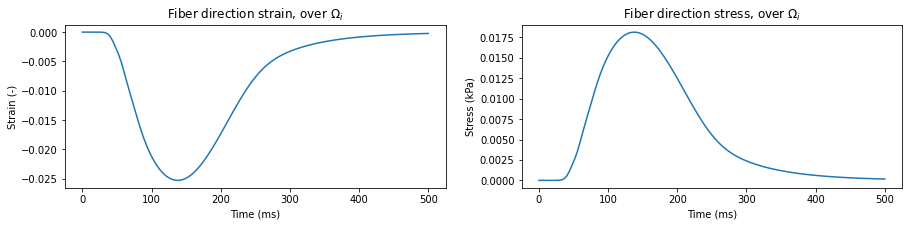

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(15, 3))

axes[0].plot(time, fiber_dir_strain_i)
axes[1].plot(time, fiber_dir_stress_i)

axes[0].set_xlabel("Time (ms)")
axes[1].set_xlabel("Time (ms)")
axes[0].set_ylabel("Strain (-)")
axes[1].set_ylabel("Stress (kPa)")

axes[0].set_title(r"Fiber direction strain, over $\Omega_i$")
axes[1].set_title(r"Fiber direction stress, over $\Omega_i$")

plt.show()

## Exercise

In the code above we ran the simulation and tracked fiber direction strain and stress values averaged over the intracellular subdomain, $\Omega_i$. We want to extend this by tracking the stress and strain values over both subdomains, and in three different directions.

For these exercises, instead of running the code for all time steps you could first try with a smaller time interval (say, for the first 50 ms); then, when you are all done, run the full simulation. This might save you a bit of time in the code developing stage, as it does take some time to run the full 500 ms time span.

1. We can also strack these over the extracellular subdomain by asking for subdomain_id $0$ instead of subdomain_id $1$. Declare new arras (or declare a twodimensional array) for the extracellular subdomain values, and extend the for loop to also track the fiber direction strain and stress values averaged over $\Omega_e$. Plot these together with the intracellular stress and strain values, over time.

2. We can next ask for stress and strain values in the perpendicular directions – the sheet direction, and the normal direction; i.e. the quantities $\overline{E_{ss}}$, $\overline{E_{nn}}$, $\overline{\sigma_{ss}}$ and $\overline{\sigma_{nn}}$ taken across $\Omega_i$ and $\Omega_j$, respectively. The functions that performs these integrals in the perpenduclar directions are called <code>evaluate_subdomain_strain_sheet_dir</code> and <code>evaluate_subdomain_strain_normal_dir</code>. As above, track these and plot them together with the other stress and strain values.

You have now almost reproduced the plot in [Paper 2, Fig. 12], however, with a coarser mesh than the one used in the paper (secondly, we also used an active stress / nearly incompressible / Guccione kind of model here, while the plot in the paper uses an active strain / fully incompressible / Holzapfel kind of model).

## Bonus exercise

The mesh given by "tile_connected_10p0.h5" is somewhat coarse. This enables fast simulations and is useful for exploring and code development. We next want to explore what happens when we refine the mesh.

1. Make a new instance of the EMI model that uses the mesh in "tile_connected_5p0.h5" (see https://github.com/aashildte/emimechanicalmodel/tree/master/meshes for an overview over all meshes available). Don't overwrite the values you already have; we'll use them for comparison. Repeat all simulations from above with the new mesh (you could do this, e.g., by copying the relevant code to a new code block, or by making the code more general by defining functions which take an EMIModel instance in as input). The new simulation will take a little bit longer, but should still run in reasonable time.

2. Focusing on the fiber direction and the intracellular subdomain, make a new subplot and compare the fiber direction strain and stress values for the two different mesh resolutions. Which is more sensitive to the mesh resolution; strain or stress values?

You have now reproduced parts of the plot in [Paper 2, Fig. 6]; with two of the same meshes as used in the paper (however, otherwise with the same modifications as mentioned above).